In [38]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import os

parent_path = os.path.abspath("./../")
if os.path.basename(parent_path) == 'vdp':
    os.chdir(parent_path)

In [39]:
custom_prediction = json.load(open('./data/sg_processed/test/custom_prediction.json'))
custom_data_info = json.load(open('./data/sg_processed/test/custom_data_info.json'))

In [41]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)


def clean_image_paths(img_list, raw_directory="./data/raw/"):
    return [raw_directory + os.path.basename(img_path) for img_path in img_list]
        

In [42]:
# parameters
image_idx = 0
box_topk = 30 # select top k bounding boxes
rel_topk = 20 # select top k relationships
ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']

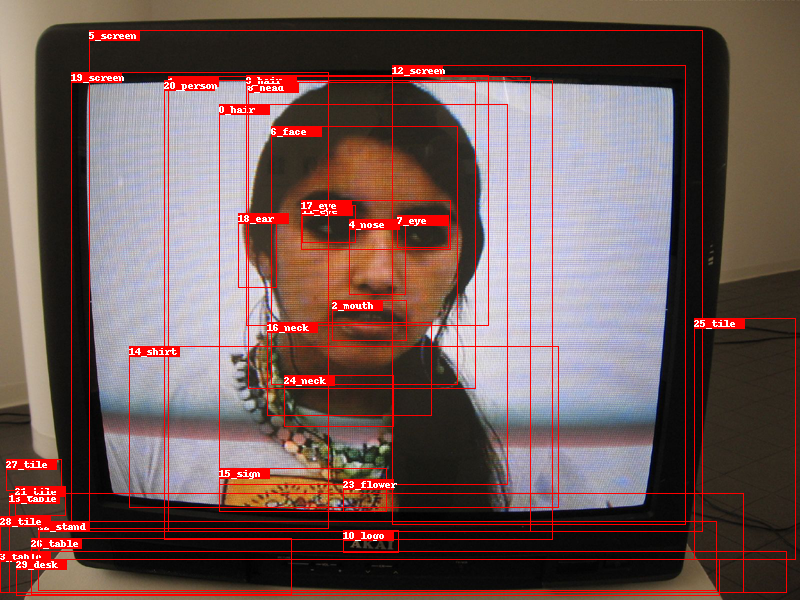

**************************************************
box_labels 0: hair; score: 0.482161283493042
box_labels 1: woman; score: 0.4687018394470215
box_labels 2: mouth; score: 0.4635107219219208
box_labels 3: table; score: 0.4206705689430237
box_labels 4: nose; score: 0.3767794668674469
box_labels 5: screen; score: 0.37585145235061646
box_labels 6: face; score: 0.3360143005847931
box_labels 7: eye; score: 0.32690465450286865
box_labels 8: head; score: 0.24776297807693481
box_labels 9: hair; score: 0.21752052009105682
box_labels 10: logo; score: 0.21364031732082367
box_labels 11: eye; score: 0.20788343250751495
box_labels 12: screen; score: 0.1966656744480133
box_labels 13: table; score: 0.16744522750377655
box_labels 14: shirt; score: 0.1457522213459015
box_labels 15: sign; score: 0.13275094330310822
box_labels 16: neck; score: 0.09155905246734619
box_labels 17: eye; score: 0.08787663280963898
box_labels 18: ear; score: 0.085535429418087
box_labels 19: screen; score: 0.07286746054887772
box

In [44]:
image_path = clean_image_paths(custom_data_info['idx_to_files'])[image_idx]
boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

for i in range(len(box_labels)):
    box_labels[i] = ind_to_classes[box_labels[i]]

rel_labels = []
rel_scores = []
for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)

rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)